In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_18_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f06ac24d720> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(16111)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

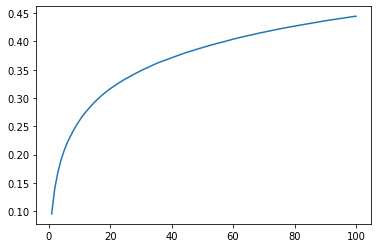

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.0951, 0.1399, 0.1681, 0.1897, 0.2062, 0.2200, 0.2314, 0.2419, 0.2514,
        0.2598, 0.2678, 0.2748, 0.2810, 0.2872, 0.2928, 0.2983, 0.3030, 0.3079,
        0.3121, 0.3163, 0.3199, 0.3237, 0.3272, 0.3306, 0.3338, 0.3367, 0.3396,
        0.3426, 0.3454, 0.3482, 0.3509, 0.3533, 0.3558, 0.3583, 0.3608, 0.3630,
        0.3651, 0.3670, 0.3690, 0.3711, 0.3731, 0.3750, 0.3770, 0.3789, 0.3807,
        0.3824, 0.3841, 0.3858, 0.3875, 0.3890, 0.3907, 0.3922, 0.3938, 0.3952,
        0.3967, 0.3982, 0.3995, 0.4010, 0.4025, 0.4040, 0.4053, 0.4067, 0.4080,
        0.4092, 0.4105, 0.4116, 0.4129, 0.4141, 0.4152, 0.4163, 0.4175, 0.4186,
        0.4198, 0.4209, 0.4220, 0.4231, 0.4241, 0.4251, 0.4260, 0.4270, 0.4280,
        0.4290, 0.4299, 0.4309, 0.4318, 0.4327, 0.4336, 0.4346, 0.4356, 0.4364,
        0.4373, 0.4382, 0.4389, 0.4398, 0.4406, 0.4414, 0.4422, 0.4430, 0.4438,
        0.4445])

In [18]:
percentages.max()

tensor(0.4445)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.57899057, 0.56309679, 0.5519429 , 0.54430948, 0.5380122 ,
       0.53293414, 0.52867764, 0.52501949, 0.52189212, 0.51897096,
       0.51645262, 0.51418078, 0.51205678, 0.51012273, 0.50823162,
       0.50647502, 0.50488549, 0.503342  , 0.5019442 , 0.50062713,
       0.49933061, 0.4981082 , 0.49695331, 0.49586835, 0.49485293,
       0.4938141 , 0.49289137, 0.49197487, 0.49107188, 0.49021316,
       0.48933344, 0.48853067, 0.48779427, 0.4870338 , 0.48630531,
       0.48563779, 0.48492481, 0.48423349, 0.48358566, 0.48295383,
       0.48235555, 0.48174837, 0.48111697, 0.48056822, 0.47996197,
       0.47942997, 0.47888567, 0.47836172, 0.47783902, 0.47734574,
       0.47687238, 0.47638907, 0.47585614, 0.4753623 , 0.47489973,
       0.4744326 , 0.47398278, 0.47353382, 0.47309327, 0.47266524,
       0.47225967, 0.47184089, 0.47143897, 0.47103069, 0.47064651,
       0.47027093, 0.46989546, 0.46951627, 0.46916887, 0.468806  ,
       0.46845476, 0.46809967, 0.46777032, 0.46742889, 0.46707

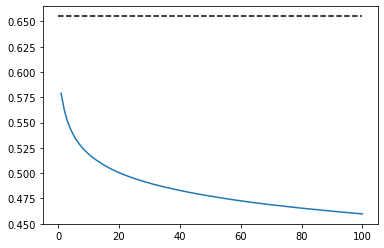

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f05aa3bc900> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(16530)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8329027801664779

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839, 130201, ...,   3202,  11950,  46987],
       [     1, 154949,  16788, ..., 114747,  76986,  45063],
       [     2,  68589, 144275, ...,   8444,  91426, 147406],
       ...,
       [169340,   9515,   2618, ..., 161030,  25700, 139180],
       [169341,  80659,   7570, ...,  68208, 168692, 131524],
       [169342, 127946, 166179, ..., 147266,  68069, 140421]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.6658055603329558

In [40]:
distances

array([[1.0000001 , 0.9843426 , 0.98274434, ..., 0.91585046, 0.91493726,
        0.91475296],
       [0.9999999 , 0.97961813, 0.9734292 , ..., 0.9316133 , 0.9314802 ,
        0.9314798 ],
       [1.        , 0.98148036, 0.97997284, ..., 0.9432844 , 0.9432045 ,
        0.9427623 ],
       ...,
       [1.0000001 , 0.9641069 , 0.9557448 , ..., 0.9060345 , 0.90601003,
        0.9058605 ],
       [1.0000002 , 0.9710169 , 0.9646839 , ..., 0.92300355, 0.9220331 ,
        0.92187375],
       [0.99999994, 0.9703807 , 0.96807206, ..., 0.9333399 , 0.932968  ,
        0.93291414]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

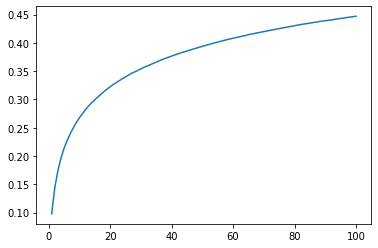

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.0976, 0.1434, 0.1736, 0.1956, 0.2131, 0.2269, 0.2390, 0.2494, 0.2590,
        0.2674, 0.2747, 0.2820, 0.2883, 0.2942, 0.2991, 0.3043, 0.3091, 0.3137,
        0.3182, 0.3224, 0.3262, 0.3297, 0.3333, 0.3366, 0.3397, 0.3431, 0.3462,
        0.3487, 0.3513, 0.3540, 0.3567, 0.3589, 0.3612, 0.3637, 0.3659, 0.3684,
        0.3706, 0.3726, 0.3747, 0.3766, 0.3786, 0.3805, 0.3824, 0.3839, 0.3856,
        0.3874, 0.3890, 0.3905, 0.3923, 0.3938, 0.3954, 0.3970, 0.3985, 0.3999,
        0.4014, 0.4029, 0.4042, 0.4056, 0.4070, 0.4082, 0.4095, 0.4107, 0.4119,
        0.4130, 0.4144, 0.4156, 0.4167, 0.4178, 0.4189, 0.4199, 0.4210, 0.4221,
        0.4231, 0.4242, 0.4251, 0.4261, 0.4272, 0.4284, 0.4293, 0.4304, 0.4314,
        0.4323, 0.4333, 0.4341, 0.4350, 0.4359, 0.4367, 0.4376, 0.4384, 0.4392,
        0.4399, 0.4406, 0.4415, 0.4424, 0.4431, 0.4439, 0.4448, 0.4456, 0.4463,
        0.4471])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.58356708, 0.56714774, 0.55660012, 0.54853315, 0.542695  ,
       0.53775572, 0.533406  , 0.52980932, 0.52674027, 0.52381321,
       0.52133674, 0.5190496 , 0.51692627, 0.51495443, 0.51317858,
       0.51152542, 0.50994796, 0.50846966, 0.50704037, 0.50570765,
       0.50450691, 0.50328247, 0.50214088, 0.50098124, 0.49987965,
       0.49895206, 0.49800394, 0.49705247, 0.49615359, 0.49527468,
       0.49447514, 0.49366725, 0.49288471, 0.49211833, 0.49137802,
       0.49064177, 0.48995809, 0.48928988, 0.48867107, 0.48801515,
       0.4874147 , 0.48677578, 0.48619459, 0.48559768, 0.48506076,
       0.48451394, 0.48396952, 0.48346674, 0.48293085, 0.48241687,
       0.48192825, 0.48146434, 0.48100099, 0.4805349 , 0.48006408,
       0.47961797, 0.47918193, 0.4787601 , 0.47831305, 0.47788384,
       0.47746842, 0.47707745, 0.47667329, 0.47626535, 0.47588059,
       0.475515  , 0.47512004, 0.47476198, 0.47439444, 0.47401487,
       0.47365065, 0.47329557, 0.47294358, 0.47258946, 0.47225

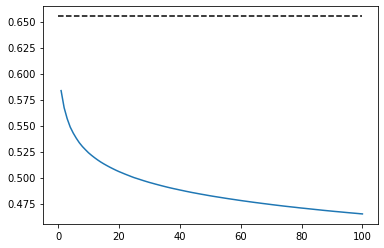

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f05aa308ea0> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(196)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

81.94840285554528

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[ 85890,  82344, 102357, ..., 140574, 127566,  74826],
       [ 48894,  91483, 147005, ...,  86225, 140091,  98613],
       [ 91497,  14745,  77164, ...,  21496,  26557,  25150],
       ...,
       [134078, 106856,  93263, ...,  78880, 132999, 164349],
       [ 99734, 168023,  24306, ...,  10337, 103121,  15627],
       [ 48894, 157435,  61033, ..., 124690,  50121,  46674]])

In [61]:
sum(embeddings[0] * embeddings[411])

162.89680571109056

In [62]:
distances

array([[203.34093, 199.51259, 199.08742, ..., 177.41292, 177.00525,
        176.85884],
       [541.7179 , 515.70483, 493.34396, ..., 431.30392, 431.20172,
        431.19476],
       [363.25043, 358.66412, 356.95395, ..., 304.48468, 304.46216,
        304.3545 ],
       ...,
       [266.74213, 248.44276, 241.01958, ..., 207.04381, 207.00432,
        206.92262],
       [282.3163 , 271.28424, 268.47037, ..., 231.77614, 231.74875,
        231.69753],
       [530.1597 , 525.59265, 523.64764, ..., 453.1424 , 453.06552,
        453.00443]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

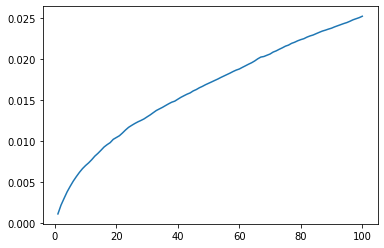

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.0012, 0.0022, 0.0030, 0.0039, 0.0045, 0.0052, 0.0057, 0.0062, 0.0067,
        0.0071, 0.0074, 0.0078, 0.0082, 0.0085, 0.0089, 0.0093, 0.0096, 0.0098,
        0.0102, 0.0105, 0.0107, 0.0110, 0.0114, 0.0117, 0.0119, 0.0122, 0.0124,
        0.0125, 0.0127, 0.0130, 0.0132, 0.0135, 0.0137, 0.0139, 0.0141, 0.0143,
        0.0146, 0.0148, 0.0149, 0.0151, 0.0154, 0.0155, 0.0157, 0.0159, 0.0161,
        0.0163, 0.0165, 0.0167, 0.0169, 0.0171, 0.0172, 0.0174, 0.0176, 0.0178,
        0.0180, 0.0181, 0.0183, 0.0185, 0.0187, 0.0188, 0.0190, 0.0192, 0.0194,
        0.0196, 0.0198, 0.0200, 0.0203, 0.0203, 0.0205, 0.0206, 0.0209, 0.0210,
        0.0212, 0.0214, 0.0216, 0.0217, 0.0219, 0.0221, 0.0222, 0.0224, 0.0225,
        0.0227, 0.0228, 0.0229, 0.0231, 0.0233, 0.0234, 0.0235, 0.0237, 0.0238,
        0.0239, 0.0241, 0.0242, 0.0243, 0.0245, 0.0246, 0.0248, 0.0249, 0.0251,
        0.0252])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.29173925, 0.29062317, 0.29641418, 0.29929197, 0.30161152,
       0.30103006, 0.29879509, 0.29722294, 0.29563995, 0.29419108,
       0.29285157, 0.29156062, 0.29037697, 0.28921437, 0.28811584,
       0.28715757, 0.28609911, 0.2852534 , 0.28450075, 0.28387533,
       0.28327123, 0.28269923, 0.2821911 , 0.28178485, 0.28141323,
       0.281159  , 0.28088948, 0.28062824, 0.28037607, 0.2800787 ,
       0.27985823, 0.27961427, 0.27932371, 0.27904399, 0.27877689,
       0.27846671, 0.27814299, 0.27780335, 0.2774725 , 0.27714815,
       0.276832  , 0.27649209, 0.27623885, 0.27591083, 0.27556485,
       0.27530887, 0.27502321, 0.27477971, 0.27451265, 0.27422994,
       0.27399779, 0.27375765, 0.2735131 , 0.27326447, 0.27299365,
       0.27271795, 0.27246828, 0.27224657, 0.27203749, 0.27182444,
       0.27162603, 0.27142612, 0.27123527, 0.27106459, 0.27092932,
       0.27076568, 0.27056576, 0.27036721, 0.27019546, 0.27002753,
       0.26986399, 0.26970704, 0.26954041, 0.26939008, 0.26923

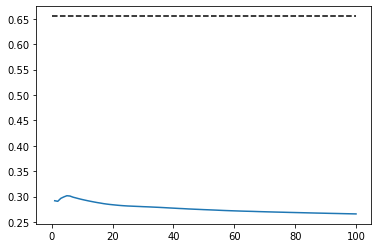

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

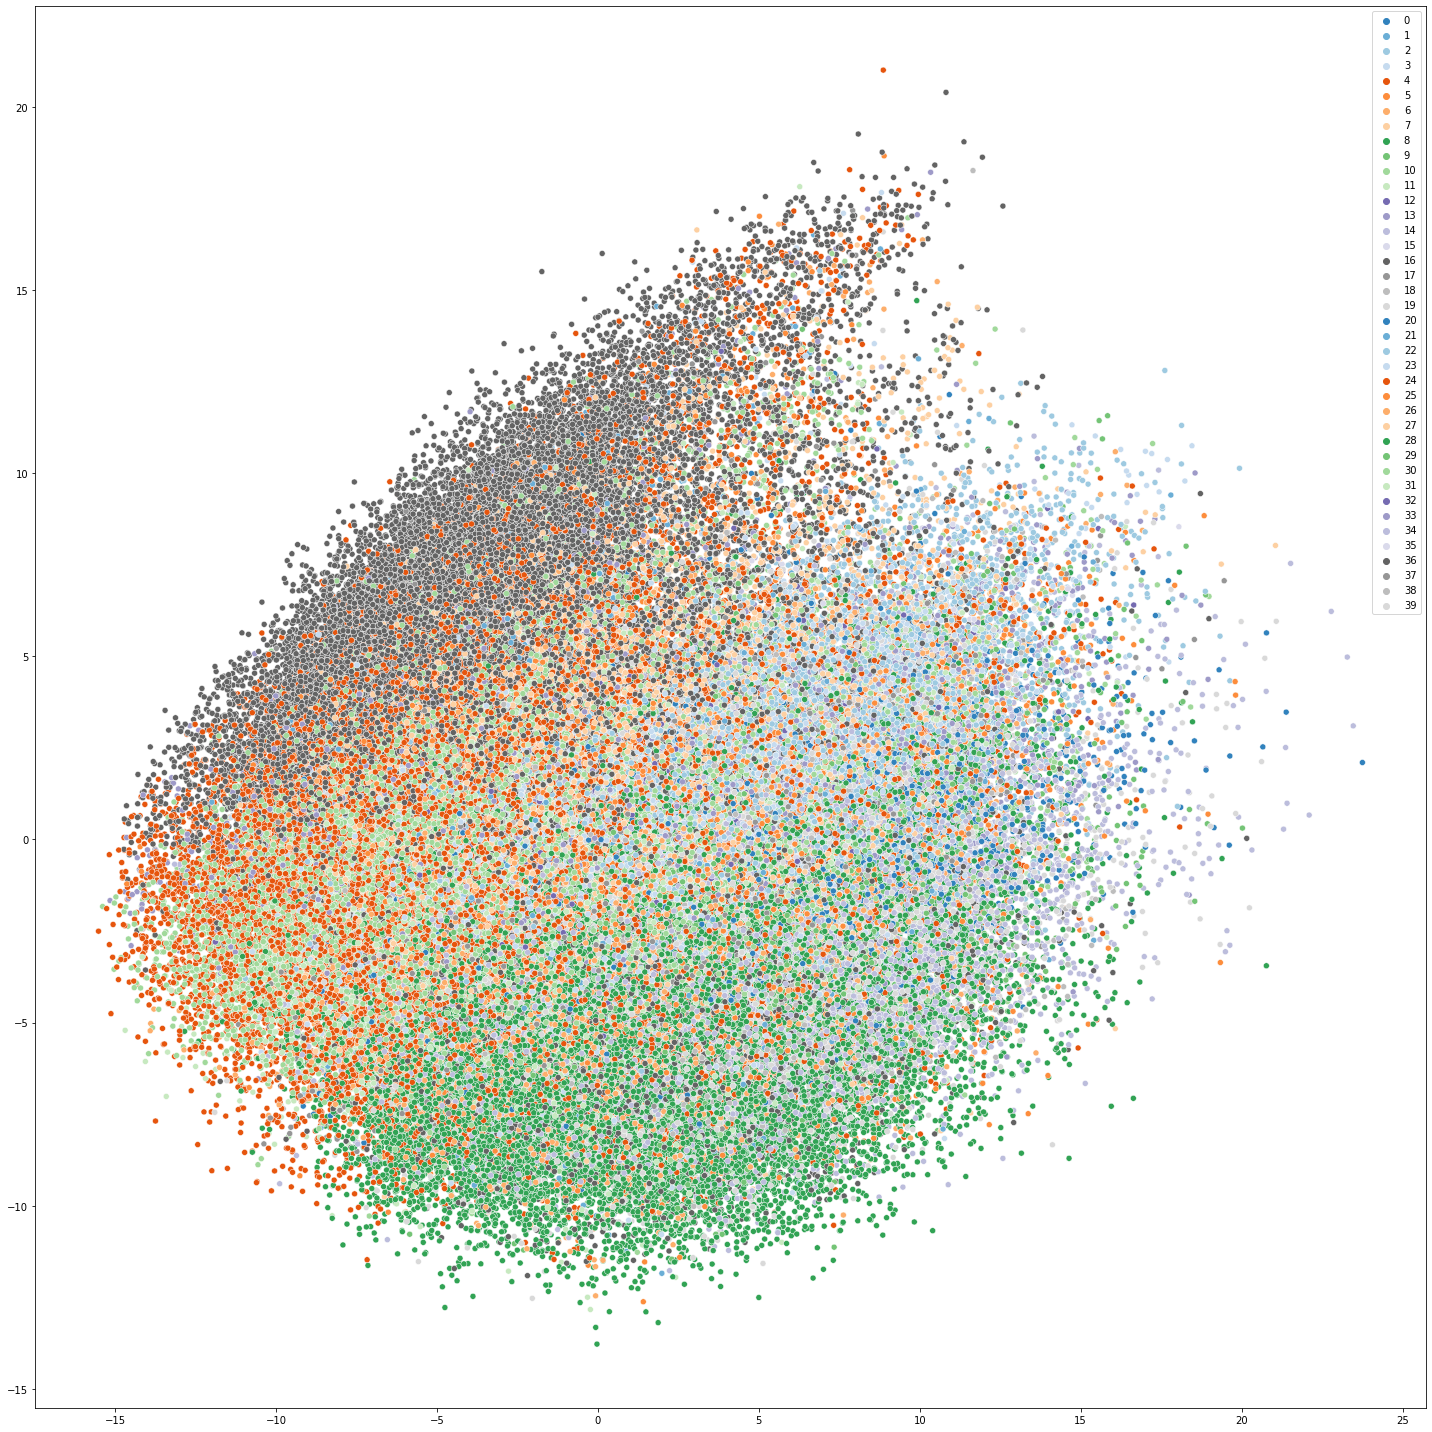

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

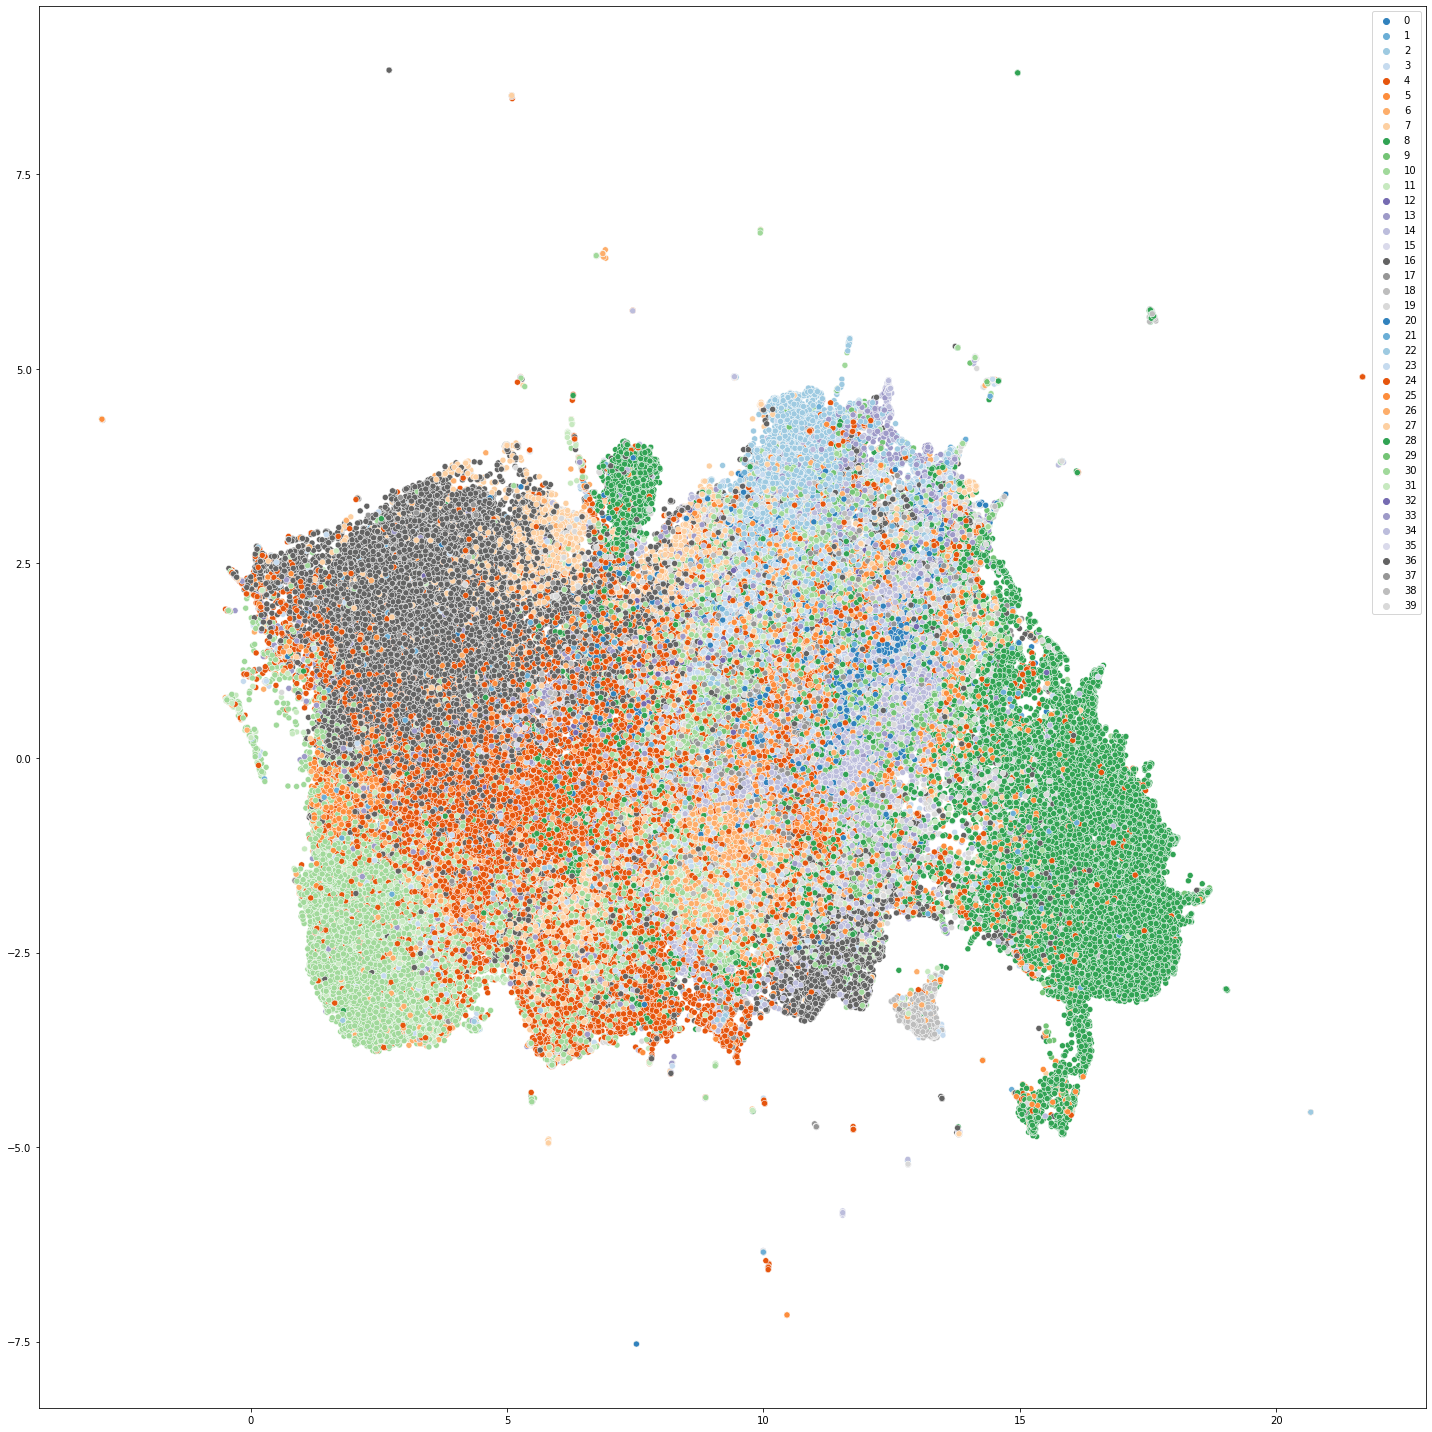

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

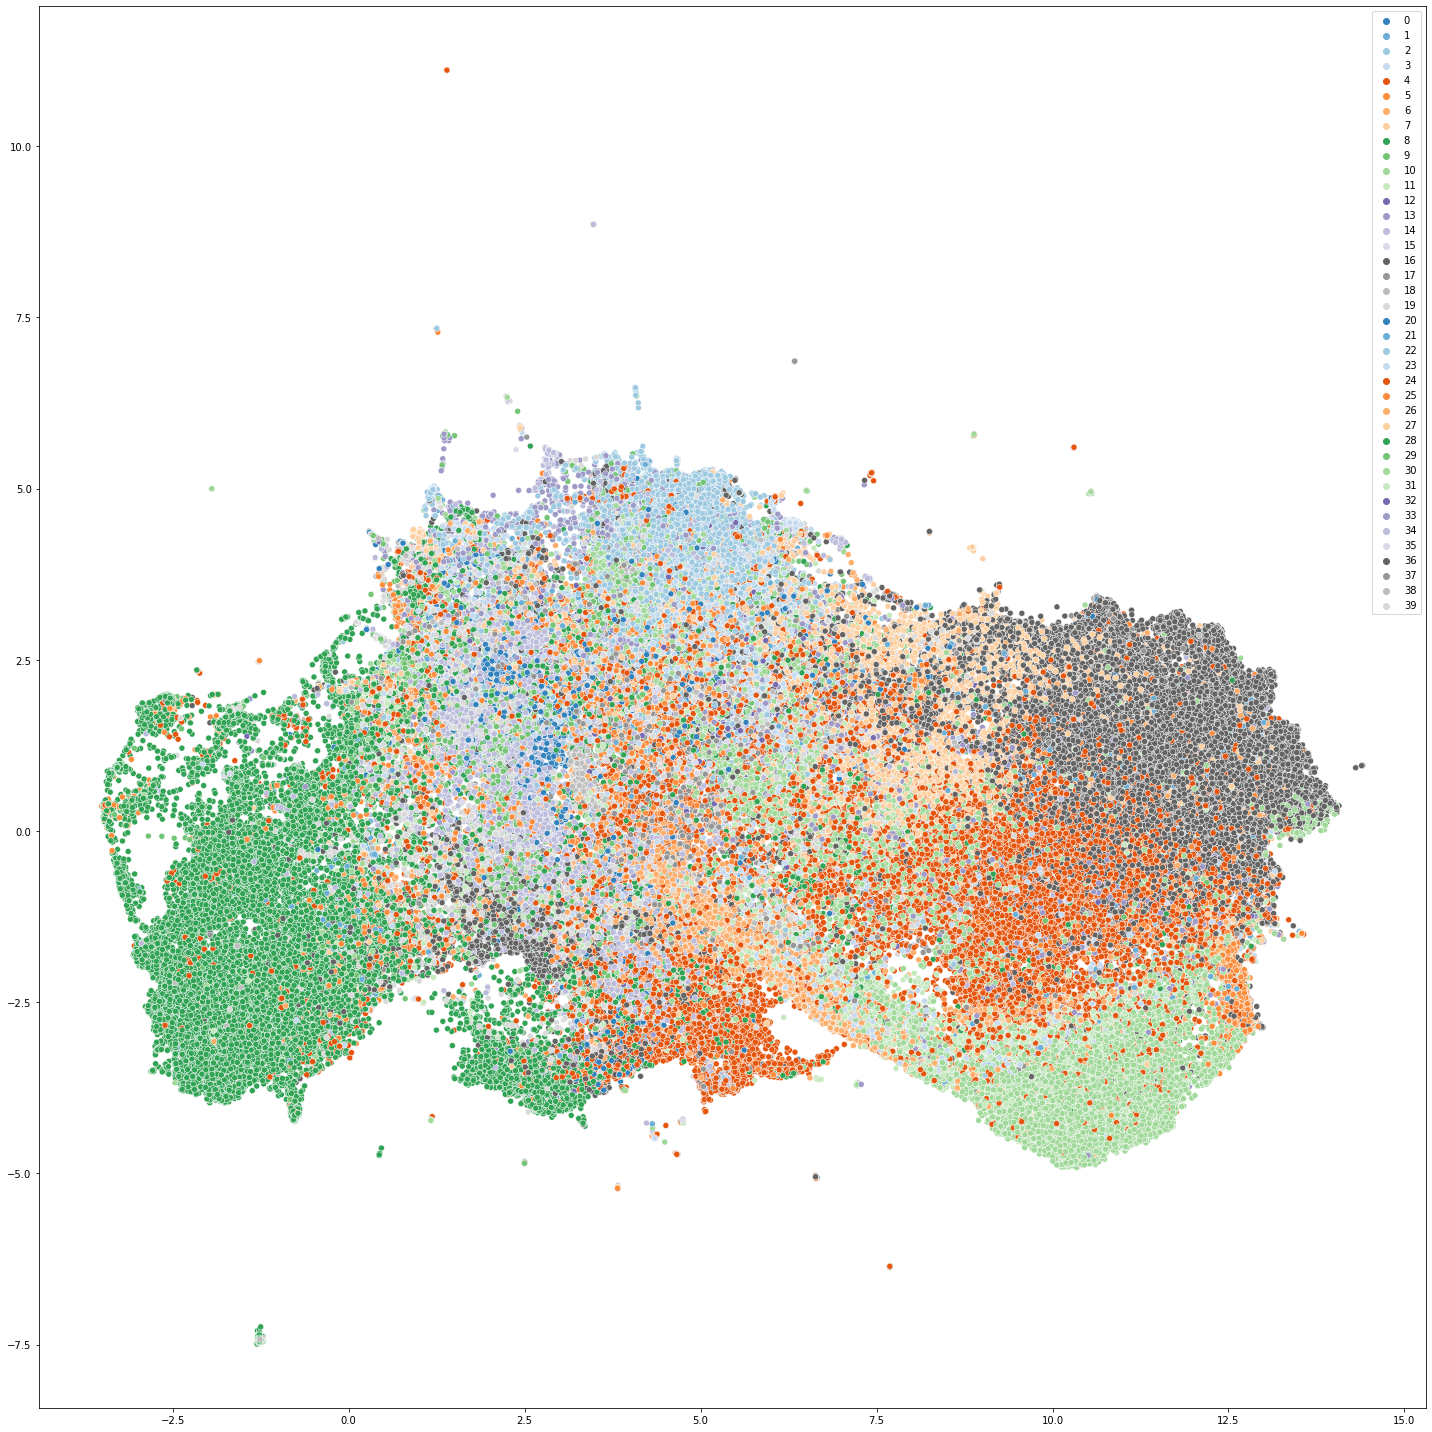

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()